In [1]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib as mlp
from matplotlib import rcParams
import itertools
import matplotlib.font_manager

In [2]:
# 플랏 기본 세팅

# 센치미터를 인치로 변환하는 함수
def cm2in(value):
    return value/2.54
# 폰트 크기 변수 
FS = 8
LEG_FS = FS-1

# 글씨 두께 변수 0.25 간격
LW = np.arange(0, 3.0, 0.25)

# 라인 스타일
DOTTED1 = (1, 1.25)
DASHDOTTED1 = (2.5, 1.25, 1.25, 1.25)
SUBPLOT_NO = list(map(chr, range(97, 123)))

In [3]:
# 기본인 폰트, 플랏 선 설정

PLT_RC_PARAMS = {
    "font": {
        "size": 8,
        # "family": "sans-serif",
        "family": "Calibri",
    },
    "pdf": {
        "fonttype": 42,
    },
    "lines": {
        "dotted_pattern": [1.0, 1.25],
        "dashed_pattern": [0.7, 9],     # only for grid line
        # "dashed_pattern": [3, 1.5],     # for data line 
        "dashdot_pattern": [1, 1.25, 4, 1.25],
    },
    "legend": {
        "columnspacing": 0.75,
        "labelspacing": 0.4,
        "numpoints": 1,         # legend number of markers
        "borderaxespad": 0.4,   # axes 틀로부터 legend 경계까지 거리 
        "handletextpad": 0.3,   # 선과 선이름 사이의 간격 
        "fancybox": False,
        
    },
    "axes": {
        "linewidth": 0.5 
    },
    "xtick": {
        "major": {
            "width": 0.5,
            "size": 2.0,
        },
        "minor": {
            "width": 0.25,
            "size": 1.0,
        },
        "direction": "in",
    },
    "ytick": {
        "major": {
            "width": 0.5,
            "size": 2.0,
        },
        "minor": {
            "width": 0.25,
            "size": 1.0,
        },
        "direction": "in",
    },
    "figure": {
        "dpi": 300
    },
    
    # Other parameters...
}


In [4]:
# csv 파일
df_T_node_data = pd.read_csv('../data/df_T.csv', encoding='cp949')
df_T_left_node_data = pd.read_csv('../data/df_T_left.csv', encoding='cp949')
df_T_right_node_data = pd.read_csv('../data/df_T_right.csv', encoding='cp949')

df_q_data = pd.read_csv('../data/df_q.csv')
df_q_in_data = pd.read_csv('../data/df_q_in.csv')
df_q_out_data = pd.read_csv('../data/df_q_out.csv')

df_Solar_data = pd.read_csv('../data/Solar data.csv', encoding='cp949')

df_exergy_c_data = pd.read_csv('../data/df_exergy_c.csv')

In [5]:
# time step, 시간 축 설정
t = 10
hour_to_sec = 3600
time_list = [t*i/hour_to_sec for i in range(len(df_T_node_data.iloc[:,[0]]))]
duration = len((df_T_node_data.iloc[:,[0]]))*t/hour_to_sec


In [7]:
T_node0 = df_T_node_data.iloc[:,[0]] #열 이름으로 뽑아내면 여러 데이터가 뽑혀서 칼럼 인덱스 번호로 추출
T_node1 = df_T_node_data.iloc[:,[1]]
T_node2 = df_T_node_data.iloc[:,[2]]
#T_node10 = df_T_node_data.iloc[:,[10]]

T_left_node0 = df_T_left_node_data.iloc[:,[0]]

T_right_node0 = df_T_right_node_data.iloc[:,[0]]

T_oa = df_Solar_data.loc[:, 'Temperature']
T_ground = df_Solar_data.loc[:, 'Ground temperature']
v_wind = df_Solar_data.loc[:, 'Wind velocity(m/s)']
Insolation = df_Solar_data.loc[:, 'Insolation to wall(W/m2)']
h_c = df_Solar_data.loc[:, 'h_c']

q_in0 = df_q_in_data.iloc[:,[0]]

exergy_c_node0 = df_exergy_c_data.iloc[:,[0]]
exergy_c_node1 = df_exergy_c_data.iloc[:,[1]]
exergy_c_node2 = df_exergy_c_data.iloc[:,[2]]
exergy_c_node3 = df_exergy_c_data.iloc[:,[3]]
exergy_c_node4 = df_exergy_c_data.iloc[:,[5]]

## Exergy consumption Plot

In [14]:
from cProfile import label

def plot(node1, node2, node3, node4, node5, node_count, plot_label):
    
    N = node_count # 노드 개수 (플랏 몇 번 그릴 건지)

    # Y_max
    Y_max = max(node1.max().max(), node2.max().max(), node3.max().max(), node4.max().max(), node5.max().max()) # 노드 추가하면 맥스 함수 추가해줘야 함

    # Y_min
    Y_min = min(node1.min().min(), node2.min().min(), node3.min().min(), node4.min().min(), node5.min().min())

    # decimal index 소숫점 제거해주기 
    d_idx = 10


    # Y_int
    Y_int = int((Y_max - Y_min)/(N*d_idx))*d_idx

    nrows = 1
    ncols = 1
    nfigs = nrows*ncols

    fig, ax = plt.subplots(
        nrows, ncols, 
        sharex=False, sharey=False, 
        figsize=(cm2in(16),cm2in(9)), 
        facecolor='w', edgecolor='k',
        squeeze=False,
        dpi = 600,
        )

    
    plot_x = time_list
    plot_y = [node1, node2, node3, node4, node5] # 노드 바꾸면 추가해야 됨
    color = ['#180f0d', '#7a1514', '#ac2a1a', '#c46d1c','#ffe100',]
    plot_label = plot_label

    # tick settings 
    xmin = [0]*nfigs #tick minimum value, nfig 갯수만큼 [ ] 생성 
    xmax = [duration]*nfigs #tick max value
    xint = [duration/6]*nfigs #tick Y_int
    xmar = [0]*nfigs

    ymin = [Y_min]*nfigs
    ymax = [Y_max + 1]*nfigs
    yint = [1]*nfigs
    ymar = [0]*nfigs

    xlabel = ["Hour [s]"]*nfigs
    ylabel = ["Exergy consumption $~\mathrm{[W/m^2]}$]"]*nfigs

    # 플랏 그리기
    for ridx in range(nrows):
        for cidx in range(ncols): 
            for i in range(N):  
            # figure index 
                idx = ncols*ridx + cidx
            
                ax[ridx, cidx].plot(
                plot_x,
                plot_y[i],
                c = color[i],
                lw = LW[3],
                label = plot_label[i]
                )
            
            # # 라벨 설정
            ax[ridx,cidx].set_xlabel(f'{xlabel[idx]}', fontsize=FS)
            ax[ridx,cidx].set_ylabel(f'{ylabel[idx]}', fontsize=FS)
            
            # 축 눈금 및 라벨 크기 설정
            ax[ridx,cidx].tick_params(direction='in', labelsize=FS, which='major', width=0.5)
            ax[ridx,cidx].tick_params(direction='in', labelsize=FS, which='minor', width=0.35)
            
            # 축 위치 설정 
            ax[ridx,cidx].set_xticks(np.arange(xmin[idx], xmax[idx]+xint[idx], xint[idx])) 
            ax[ridx,cidx].set_yticks(np.arange(ymin[idx], ymax[idx]+yint[idx], yint[idx])) 
            
            # x,y 값 제한 
            ax[ridx,cidx].set_xlim(xmin[idx]-xmar[idx], xmax[idx]+xmar[idx])
            ax[ridx,cidx].set_ylim(ymin[idx]-ymar[idx], ymax[idx]+ymar[idx])
            ax[ridx,cidx].margins(x=0, y=0.1)
            
            # 보조 눈금의 수
            ax[ridx,cidx].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            ax[ridx,cidx].yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
            
            # 그리드 설정 
            ax[ridx,cidx].grid(True, axis='both', linestyle='--', linewidth=LW[1], color='0.25');    
            
            # legend 
            handles, labels = ax[ridx,cidx].get_legend_handles_labels()
            legorder1 = range(len(handles))
            ax[ridx,cidx].legend([handles[idx] for idx in legorder1],
                                [labels[idx] for idx in legorder1], 
                                loc='upper right', ncol=1, bbox_to_anchor=(0.96, 0.99), frameon=False, 
                                edgecolor='None', facecolor='None',
                                fontsize=LEG_FS, fancybox=False, 
                                columnspacing= 1.05, labelspacing=0.4)
        
            # 그래프 외곽 라인 설정     
            for k in ['top','bottom','left','right']:
                    ax[ridx,cidx].spines[k].set_visible(True)
                    ax[ridx,cidx].spines[k].set_linewidth(0.5)
                    ax[ridx,cidx].spines[k].set_color('k')  
                    
    # Margin adjustment.
    fig.align_labels()
    fig.tight_layout(pad=0.2, h_pad=0.2)
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

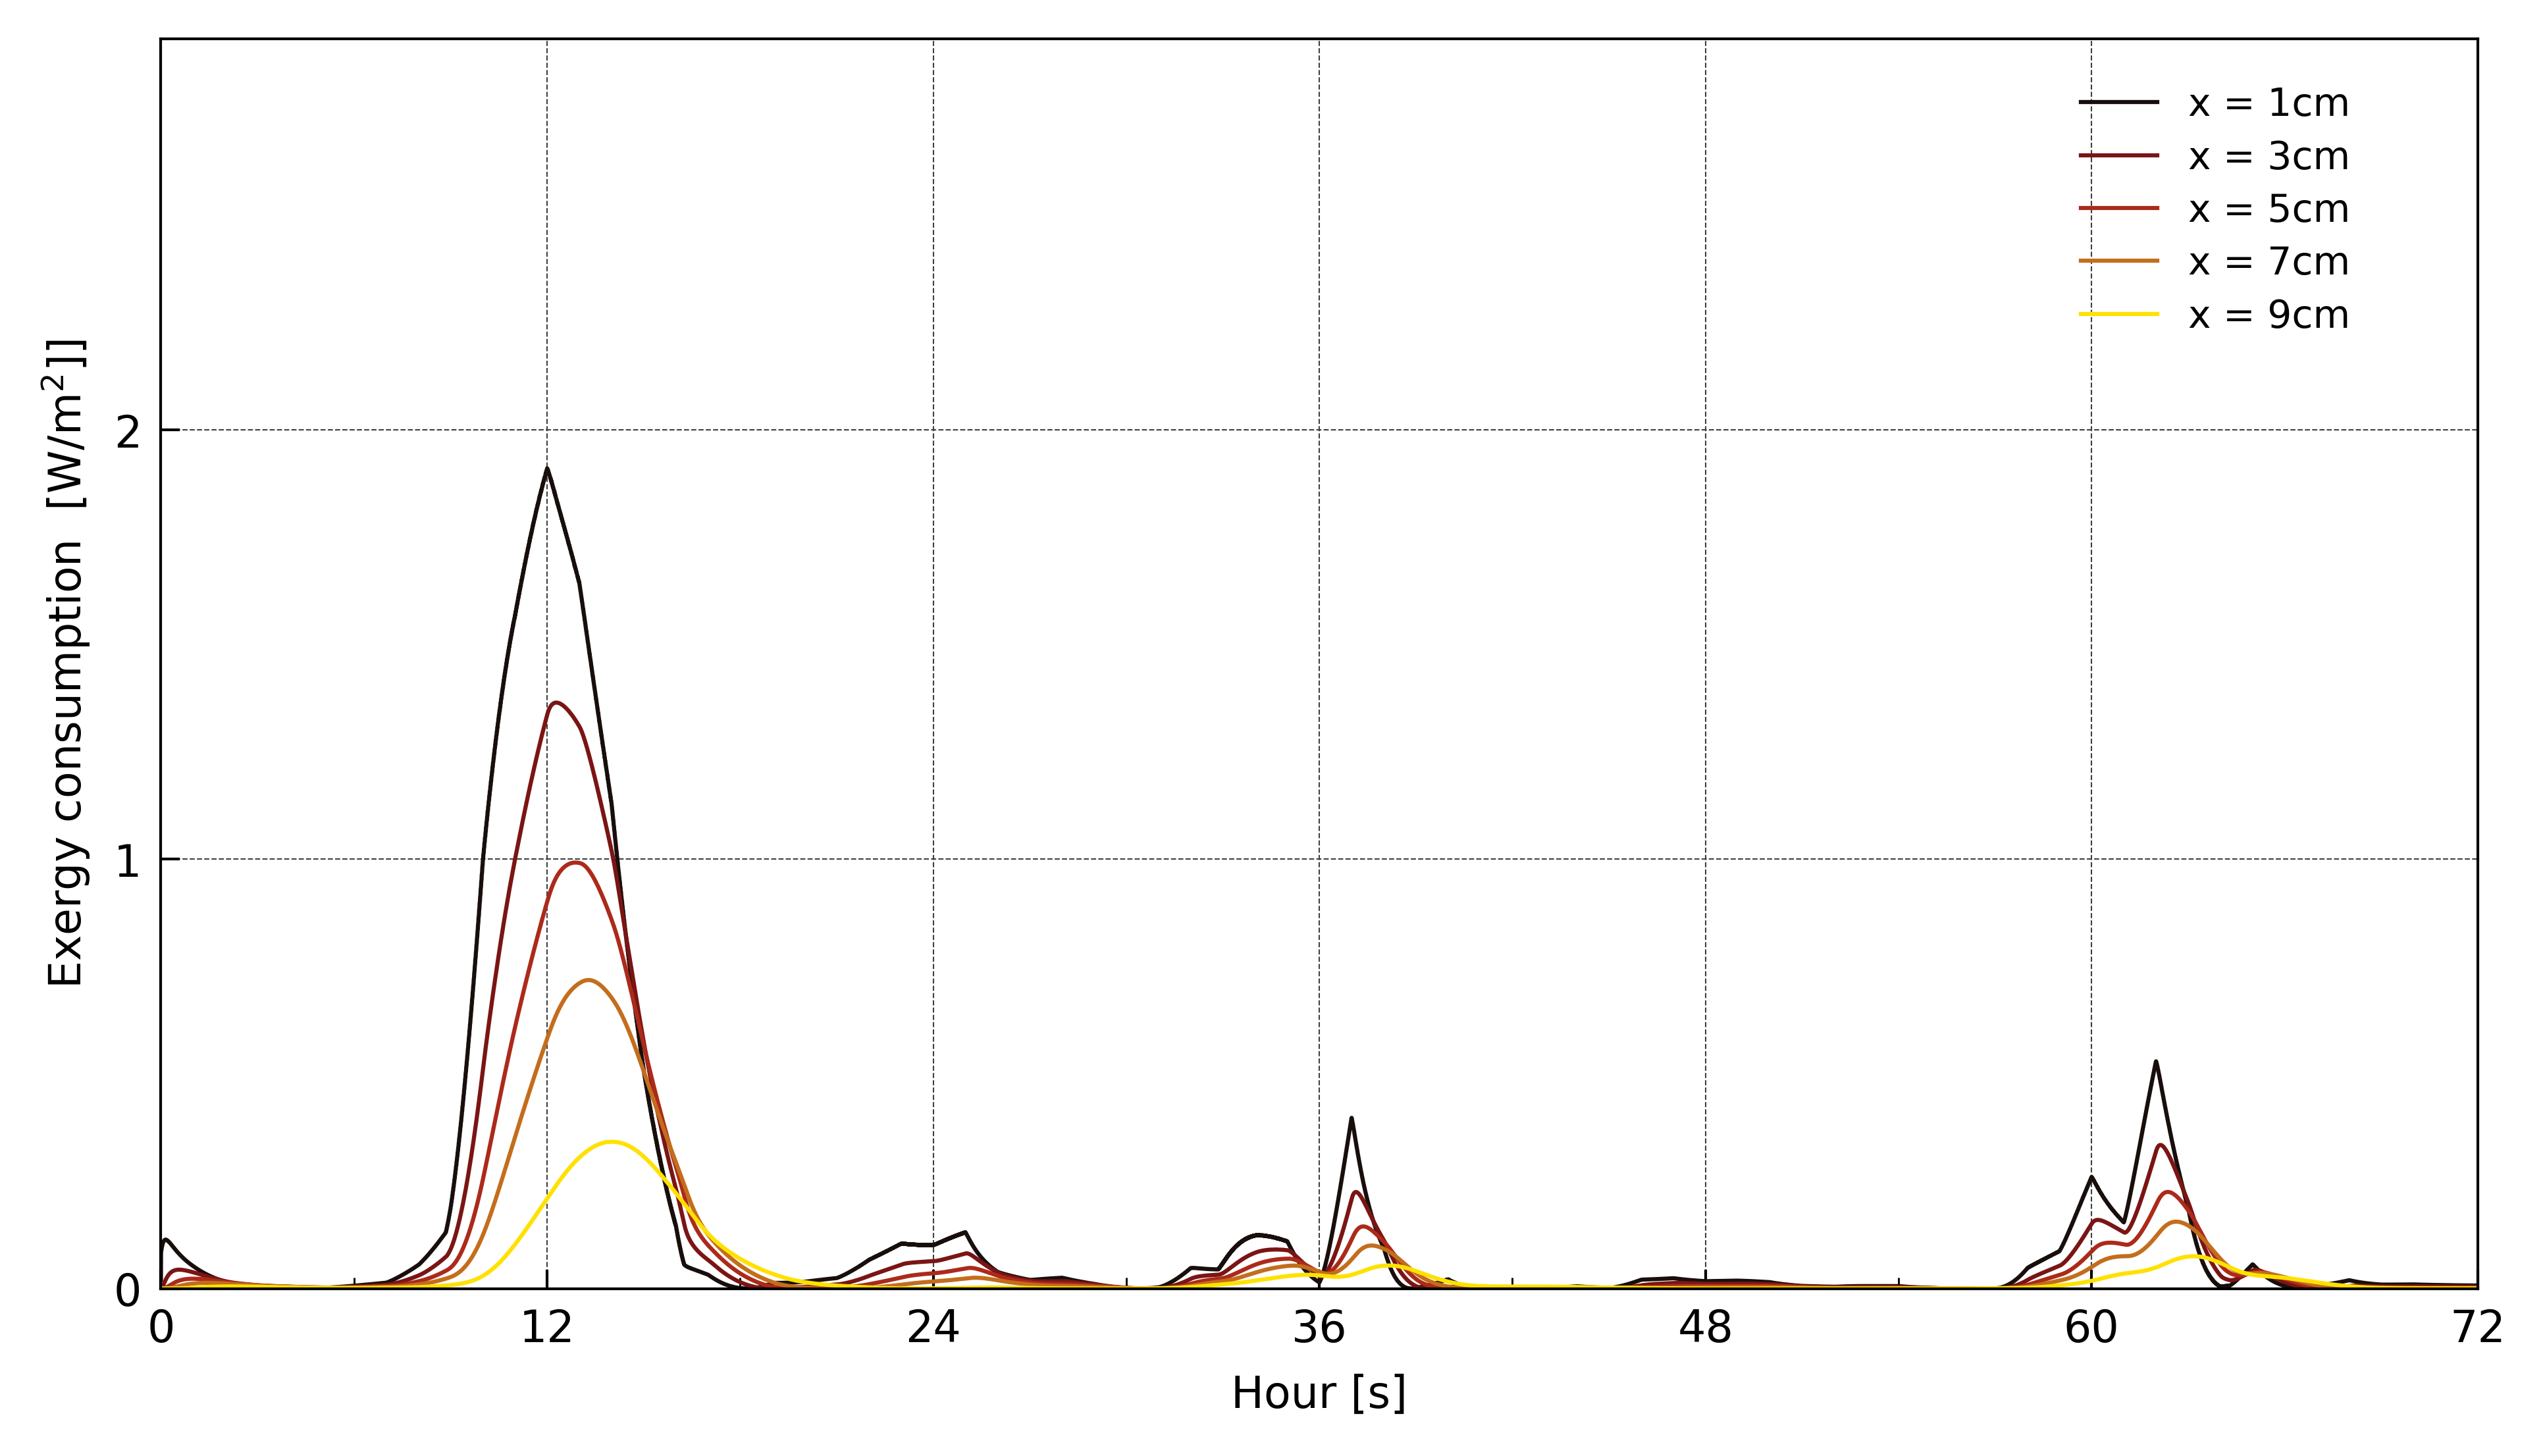

In [15]:
plot(exergy_c_node0, exergy_c_node1, exergy_c_node2, exergy_c_node3, exergy_c_node4, 5,
     ("x = 1cm", "x = 3cm", "x = 5cm", "x = 7cm", "x = 9cm"))